In [43]:
%%capture 
%load_ext autoreload
%autoreload 2
%reset -f

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import spectrogram
from cmath import cos, sin, pi
import math
from scipy.interpolate import interp1d
from math import sqrt

In [45]:
# Plot and save the PSD of the signal
# f, PSD_eeg = PSD_cp(eeg_filtered,fs,False,target_frequencies,chan_name)
def PSD_cp(eeg_data,fs,plot,target_frequencies,chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']):
    # Calculate the PSD of the filtered signal 
    f, Pxx_den = signal.welch(eeg_data, fs, nperseg=1024) # Given a 256 Hz sampling rate, the PSD is calculated over 4 second windows

    if (plot == True):
        # Plot the PSD for each channel of the filtered signal
        for i in range(len(eeg_data)):
            plt.figure()
            #Add some visible lines at the target frequencies 
            for j in range(len(target_frequencies)):
                plt.axvline(x=target_frequencies[j], color='r', linestyle='--')
                
            plt.semilogy(f[0:201], Pxx_den[i][0:201])
            plt.xlabel('frequency [Hz]')
            plt.ylabel('PSD [V**2/Hz]')
            plt.title(chan_name[i])
            plt.show()
    return f, Pxx_den

In [46]:
# Plot and save the Spectrogram of the signal 
#freqs, t, Sxx = spectrogram_cp(eeg_filtered,fs,False,chan_name)
def spectrogram_cp(eeg_data,fs,plot,chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']):
    # Define parameters for spectrogram
    nperseg = 1024  # Number of samples per segment
    noverlap = 512  # Number of samples overlapping between segments
    f_range = [1, 40]  # Frequency range of interest in Hz

    # Loop through each channel
    for channel_index in range(len(eeg_data)):
        # Compute the spectrogram for the current channel
        freqs, t, Sxx = spectrogram(eeg_data[channel_index], fs, nperseg=nperseg, noverlap=noverlap)

        # Select the frequency range of interest
        freq_idx = (freqs >= f_range[0]) & (freqs <= f_range[1])
        freqs = freqs[freq_idx]
        Sxx = Sxx[freq_idx, :]

        if (plot == True):
            # Plot the spectrogram and some visible lines at target_freqs in Hz
            plt.pcolormesh(t, freqs, 10 * np.log10(Sxx), cmap='jet')
            plt.colorbar(label='dB/Hz')
            plt.xlabel('Time (s)')
            plt.ylabel('Frequency (Hz)')
            plt.title('Time-Frequency Spectrogram for Channel ' + chan_name[channel_index])
            plt.show()
    return freqs, t, Sxx

In [47]:
#SNR_left, SNR_center, SNR_right = zones_SNR_cp(eeg_array, target_frequency, fs, False,left_channels_index,center_channels_index,right_channels_index,chan_name)
def zones_SNR_cp(eeg_data,target_frequency,fs,plot,left_channels_index,center_channels_index,right_channels_index,chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']):
    f, PSD_eeg = PSD_cp(eeg_data,fs,False,chan_name)

    # Calculate the average PSD of each zone  and plot it
    PSD_left = np.mean(PSD_eeg[left_channels_index], axis=0)
    PSD_center = np.mean(PSD_eeg[center_channels_index], axis=0)
    PSD_right = np.mean(PSD_eeg[right_channels_index],axis=0)
    #Keep only the frequencies between 1 and 40 Hz
    freq_idx = np.where((f >= 1) & (f <= 40))
    f = f[freq_idx]
    PSD_left = PSD_left[freq_idx]
    PSD_center = PSD_center[freq_idx]
    PSD_right = PSD_right[freq_idx]

    if (plot == True):
        # Plot the average PSD of each zone
        plt.figure()
        plt.plot(f, PSD_left, label='Left')
        plt.plot(f, PSD_center, label='Center')
        plt.plot(f, PSD_right, label='Right')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power (dB)')
        plt.title('Average PSD of each zone')
        plt.legend()
        plt.show()

    # Calculate the power for the target frequency in each zone
    power_left = np.mean(PSD_left[np.where((f >= target_frequency-1) & (f <= target_frequency+1))])
    power_center = np.mean(PSD_center[np.where((f >= target_frequency-1) & (f <= target_frequency+1))])   
    power_right = np.mean(PSD_right[np.where((f >= target_frequency-1) & (f <= target_frequency+1))])

    # Calculate the SNR for the target frequency in each zone 
    SNR_left = power_left/np.mean(PSD_left[np.where((f >= 1) & (f <= 40))])
    SNR_center = power_center/np.mean(PSD_center[np.where((f >= 1) & (f <= 40))])
    SNR_right = power_right/np.mean(PSD_right[np.where((f >= 1) & (f <= 40))])
    
    return SNR_left, SNR_center, SNR_right

In [73]:
# Paper rls filter function
def rls_filter(y, f,lambda_, fs, delta):
    # Recursive Least Squares (RLS) filter from the paper : https://pubmed.ncbi.nlm.nih.gov/7750452/
    # An adaptive filter for steady-state evoked responses.
    
    # y is the input signal -> EEG signal in our case. But in the paper y is interpreted as the desired signal.
    # x is the frequency of interest.
    # P is the number of filter coefficients -> our case fixed at 2. In terms of RLS filter, 
    # the number of coefficients is actually 1 since we only work with most recent sample
    P = 2
    # lambda_ is the forgetting factor. Usually between 0.9 and 0.999
    # delta is the initial value of the inverse correlation matrix. Usually some small value like 0.001
    
    # Initialize the filter coefficients. P is fixed at 2 in our case.
    w_all = np.zeros([P, len(y)])
    
    #Initialize the desired signal. This the paper interprets as the input signal.
    x1 = np.zeros([len(y),1]) 
    x2 = np.zeros([len(y),1])
    x = np.zeros([2,len(y)])
    # Make x1 a sine of the desired frequency f
    x1 = np.sin(2*np.pi*f*np.arange(0,len(y),1)/fs)
    # Make x2 a cosine of the desired frequency f
    x2 = np.cos(2*np.pi*f*np.arange(0,len(y),1)/fs)
    # Stack x1 and x2 to make x
    x = np.vstack((x1,x2)) 
    
    # Initialize the inverse correlation matrix as a numpy array
    R = delta*np.eye(P) 
    
    # Initialize the output signal
    y_hat = np.zeros([len(y),1])
    
    # Initialize the error signal
    e = np.zeros([len(y),1])
    
    # Loop through the samples one by one
    for i in range(0,len(y)):
        
        # 1. Compute the adaptation gain
        k_num = (1/lambda_)*(R@x[:,i])  
        k_den = 1 + (1/lambda_)*(x[:,i].T@R@x[:,i])
        k  = k_num/k_den
        k = np.reshape(k, (P,1))

        # 2. Error signal & update signal estimate
        y_hat[i] = (w_all[:,i-1].T)@x[:,i]
        e[i] = y[i] - y_hat[i] 
        
        # 3. Update the filter coefficients
        w_all[:,i] = w_all[:,i-1] + k@e[i]
    
        # 4. Update the inverse correlation matrix
        x_temp = np.reshape(x[:,i], (2,1))
        R = (1/lambda_) * R - (1/lambda_)* k@x_temp.T@R     
        
    return y_hat,w_all

In [50]:
# new_array = correct_size(array)
def correct_size(arr):
    # Check if the input is a valid NumPy array
    if not isinstance(arr, np.ndarray):
        raise ValueError("Input must be a NumPy array")

    # Get the length of the array
    number = arr.shape[1]

    # Find the logarithm base 2 of the number
    log2_number = math.log2(number)

    # Calculate the lower and upper powers of two
    lower_power_of_two = 2 ** math.floor(log2_number)
    upper_power_of_two = 2 ** math.ceil(log2_number)

    # Calculate the distances to the lower and upper powers of two
    distance_lower = abs(number - lower_power_of_two)
    distance_upper = abs(number - upper_power_of_two)

    # Return the closest power of two, whether it is higher or lower than the length of the array
    if distance_lower <= distance_upper:
        #return a temporary array which has the values of arr but removed enough so its closest power of 2
        return arr[:,0:lower_power_of_two]
    else:
        #return a temporary array which has the values of arr but zero padded enough so its closest power of 2
        return np.pad(arr, ((0,0),(0,upper_power_of_two-number)), 'constant', constant_values=(0))


In [51]:
# Load the raw EEG data
eeg_data = pd.read_csv("data/Liuyin-5April/Morning/wet_17hz_0504_clean_ExG.csv")
chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']
# Set the sampling rate and the filter cutoff frequencies
fs_original = 250  # Hz
# fs = 250 Hz & Closest power of 2 to 256 -> Will upsample first before filtering
low_cutoff = 1
high_cutoff = 40
target_frequency = 17
target_frequencies = [10,16,17,18] # Best to use harmonics of the target frequency 

#Create two dataframes from eeg_data: timestamp and eeg
eeg_data_timestamp = eeg_data.iloc[:,0]
eeg_data_eeg = eeg_data.iloc[:,1:]

# Create an array of the EEG data
eegarray = eeg_data_eeg.to_numpy() 
eegarray = eegarray.T 

# Desired sampling frequency after upsampling
fs = 256  # Hz

# Upsampling factor
upsample_factor = fs / fs_original

# Upsample data along the second axis (time axis)
eeg_array = np.zeros((eegarray.shape[0], int(eegarray.shape[1] * upsample_factor)))
for i in range(eegarray.shape[0]):
    f = interp1d(np.arange(eegarray.shape[1]), eegarray[i, :], kind='linear')
    eeg_array[i, :] = f(np.arange(0, eegarray.shape[1]-1, 1/upsample_factor))

# Print upsampled data shape
print("Original data shape:", eegarray.shape)
print("Upsampled data shape:", eeg_array.shape)

# Make size of EEG data a power of two to make computations faster
eeg_array = correct_size(eegarray)
print(eeg_array.shape)    

# Apply a bandpass filter to the EEG data 
b, a = signal.butter(4, [low_cutoff/(fs/2), high_cutoff/(fs/2)], btype='bandpass')
eeg_filtered = signal.filtfilt(b, a, eeg_array, axis=1)

# Get information about the EEG data

# Get length of the EEG data
samples_nr = len(eeg_filtered[0])
print(samples_nr)

# Get number of channels
channel_nr = len(eeg_filtered)
print(channel_nr)


# Introduce information about the channels
left_channels = ['PO3', 'PO7', 'O1']
center_channels = ['POz', 'Oz']
right_channels = ['PO4', 'PO8', 'O2']
zone_names = ['Left', 'Center', 'Right']

# Convert the channels to the corresponding index from chan_name
left_channels_index = [chan_name.index(i) for i in left_channels]
center_channels_index = [chan_name.index(i) for i in center_channels]
right_channels_index = [chan_name.index(i) for i in right_channels]


Original data shape: (8, 40672)
Upsampled data shape: (8, 41648)
(8, 32768)
32768
8


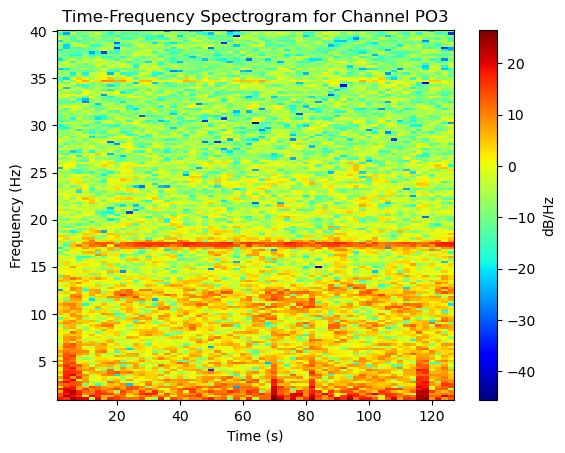

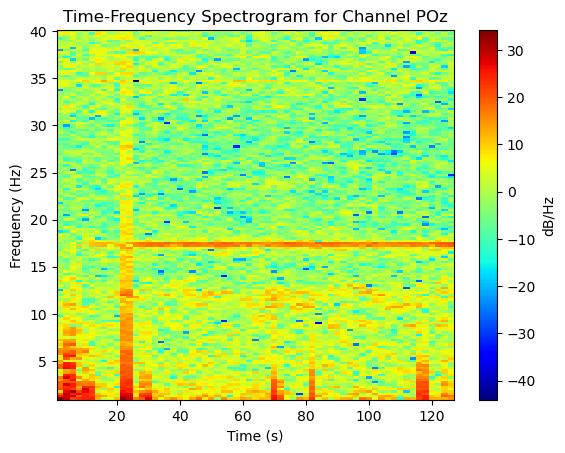

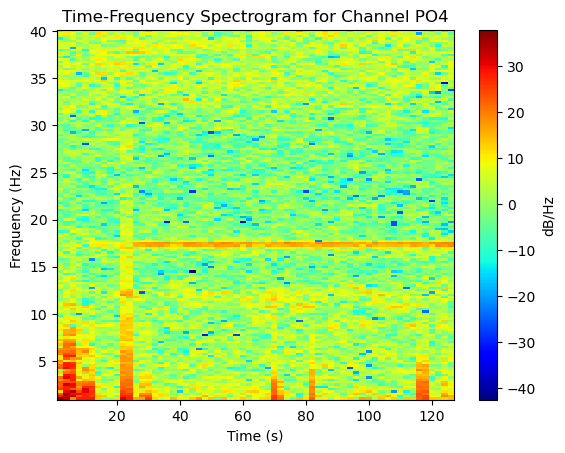

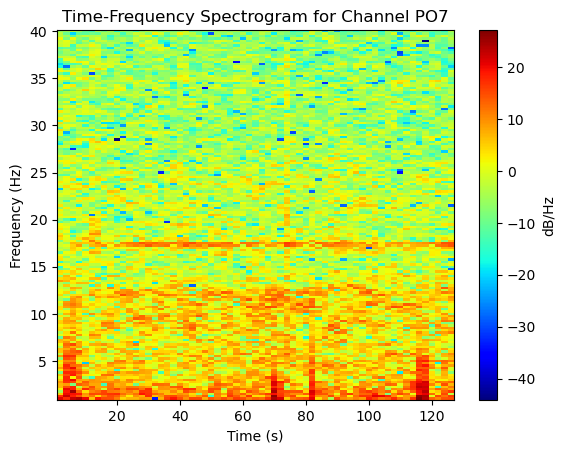

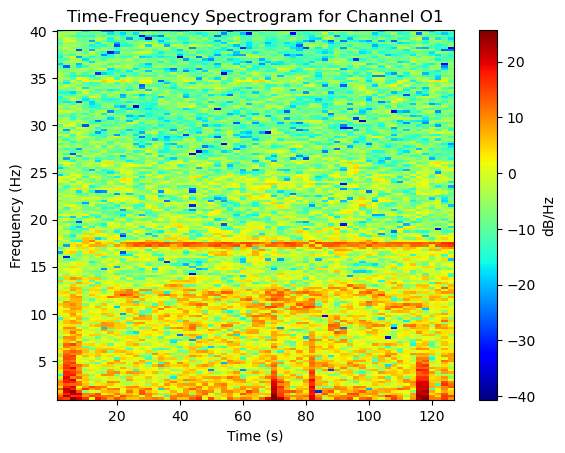

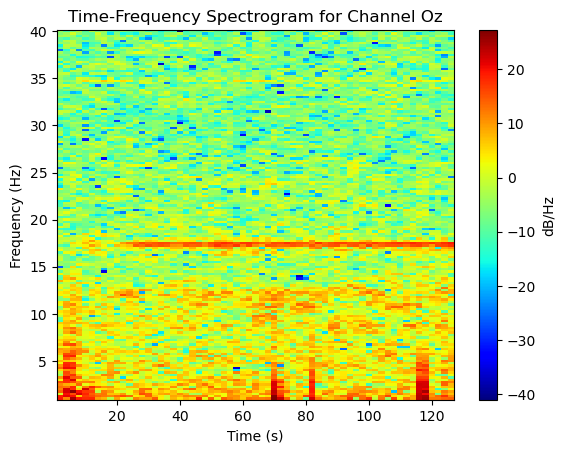

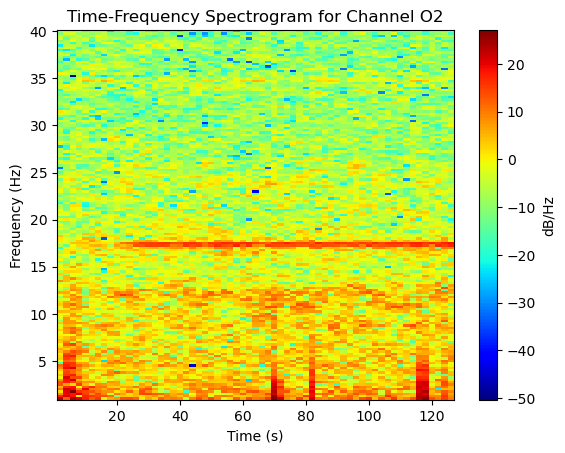

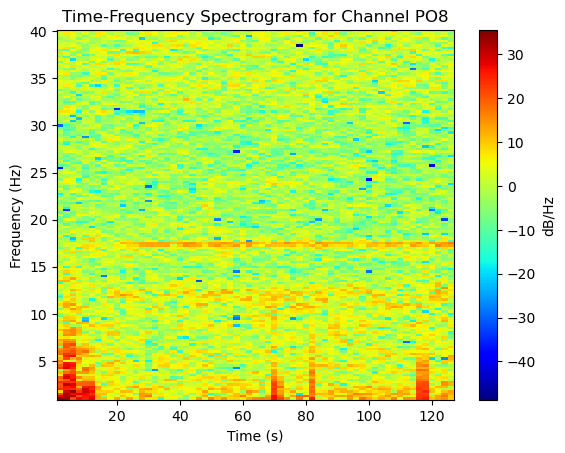

In [63]:
# Plot the PSD of the EEG data using PSD_cp function
f, t__,Spect_eeg = spectrogram_cp(eeg_array,fs,True,chan_name)

In [54]:
## This part is for the RLS filter from the paper.
# Apply the recursive least squares filter to each of the channels in the EEG signal with a target frequency of 17 Hz
y_hat = []
# Initialize a list to store the RLS filter coefficients
filter_coefficients = []

for i in range(len(eeg_filtered)):
    # Apply the RLS filter to the EEG signal
    sig, coeff = rls_filter(eeg_filtered[i],17,0.95,fs,1e-4)
    # Append the filtered signal to the list y_hat
    y_hat.append(sig)
    # Append the filter coefficients to the list filter_coefficients
    filter_coefficients.append(coeff)

# Transpose all elements in the list y_hat so that they are in the same format as the EEG signal
for i in range(len(y_hat)):
    y_hat[i] = y_hat[i].T

# Rearrange y_hat so it has same dimensions as eeg_array 
y_hat = np.array(y_hat)
y_hat = np.reshape(y_hat, (eeg_filtered.shape[0], eeg_filtered.shape[1]))


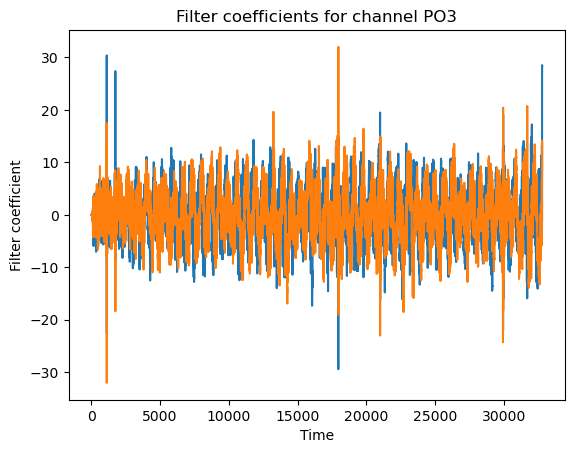

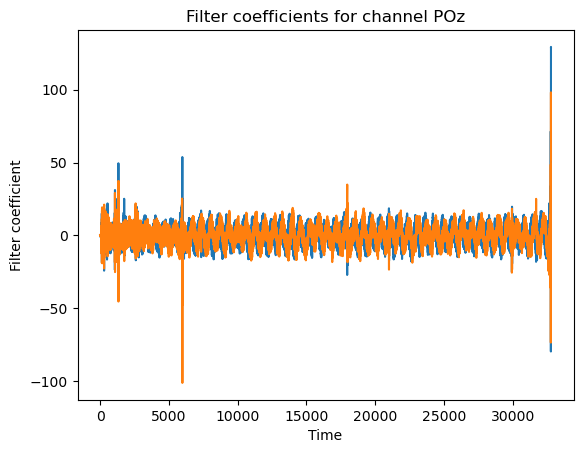

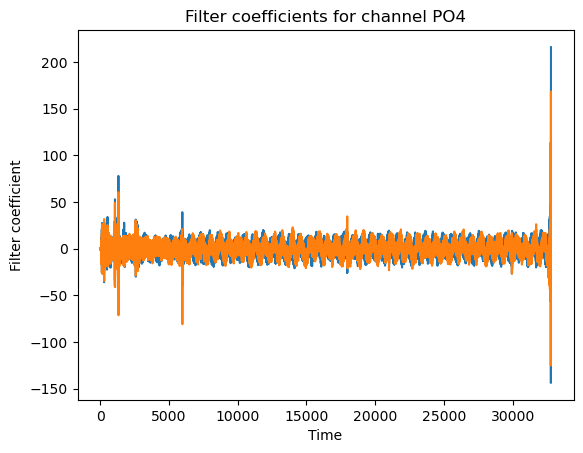

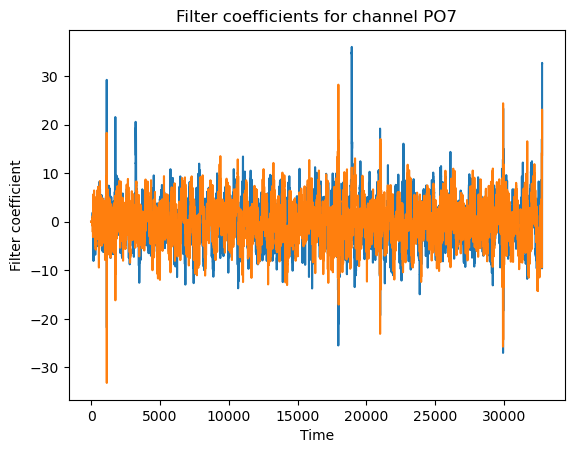

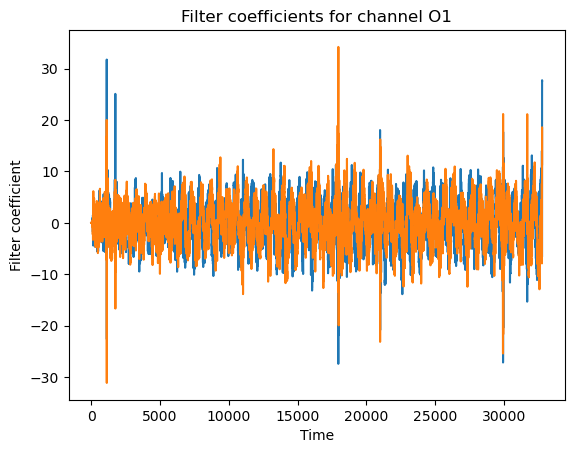

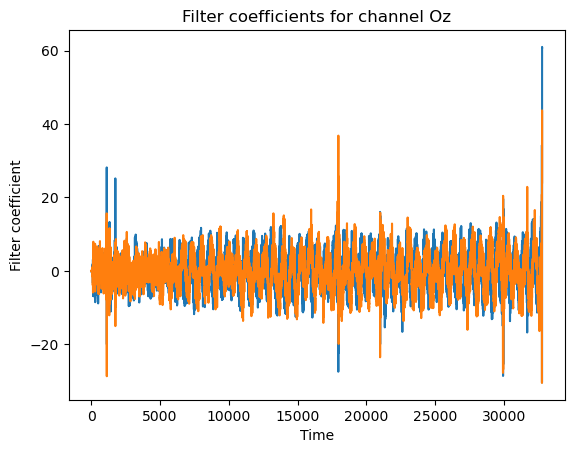

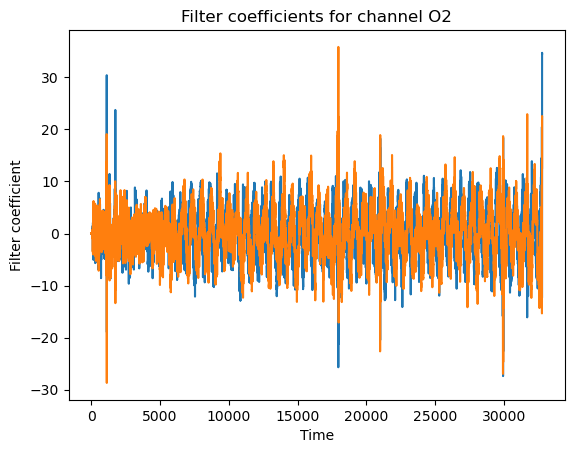

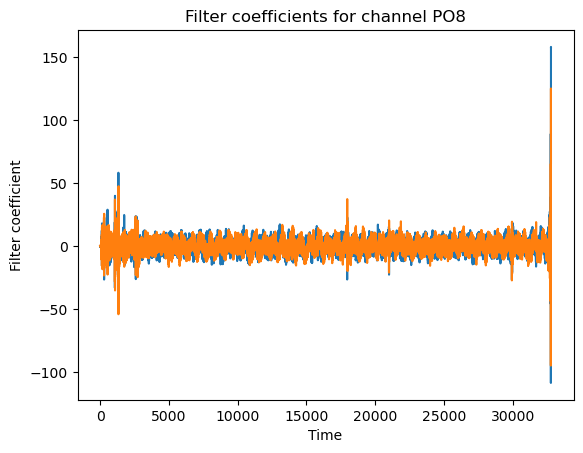

In [61]:
# Plot the filter coefficients for each chan
for i in range(len(filter_coefficients)):
    plt.figure()
    for j in range(len(filter_coefficients[i])):
        plt.plot(filter_coefficients[i][j])
        plt.title("Filter coefficients for channel " + chan_name[i])
        plt.xlabel("Time")
        plt.ylabel("Filter coefficient")
    plt.show()

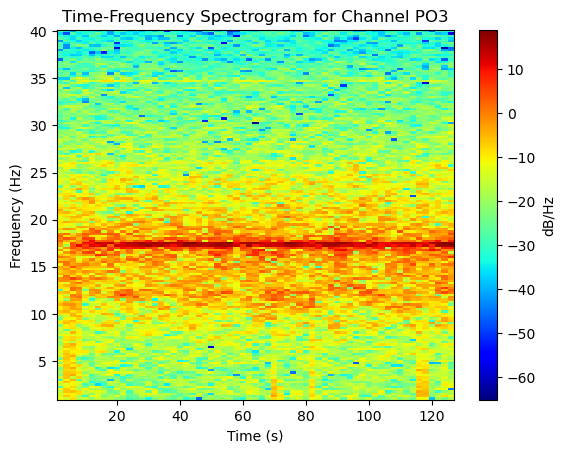

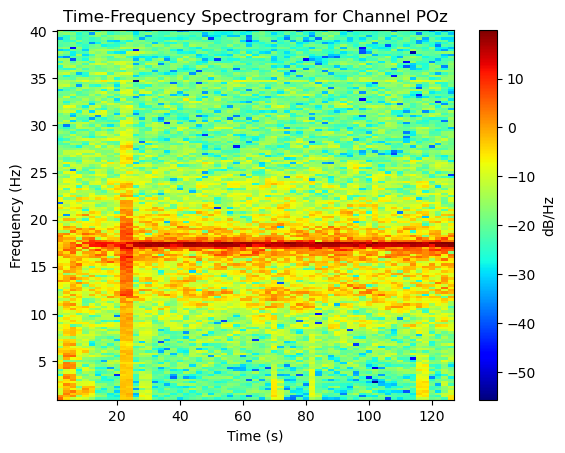

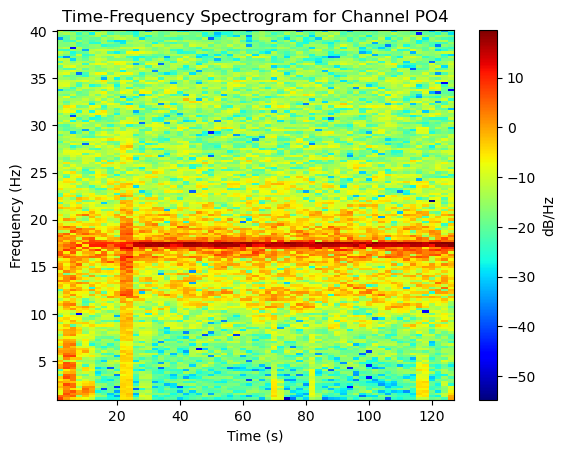

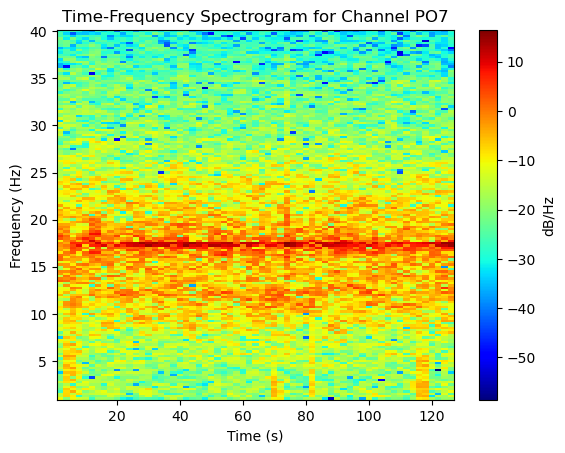

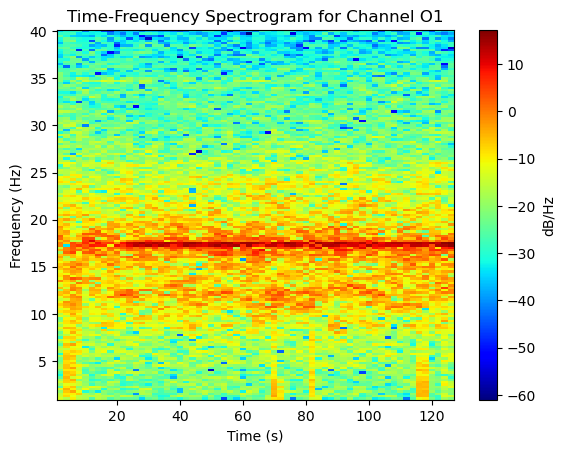

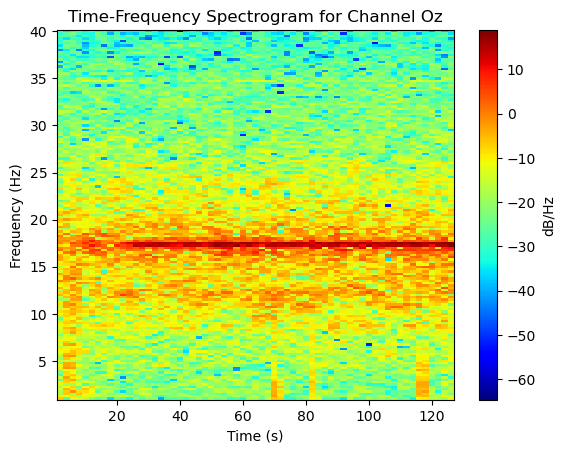

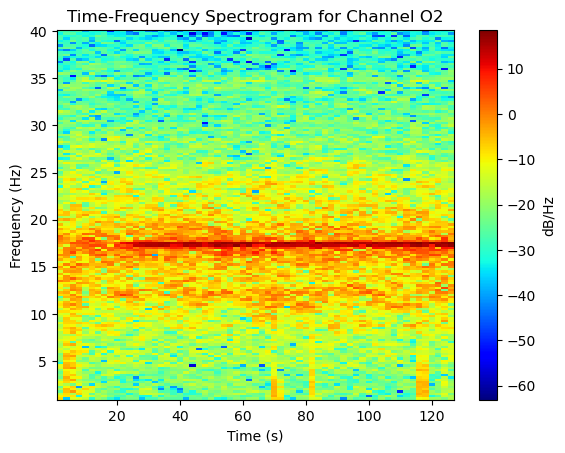

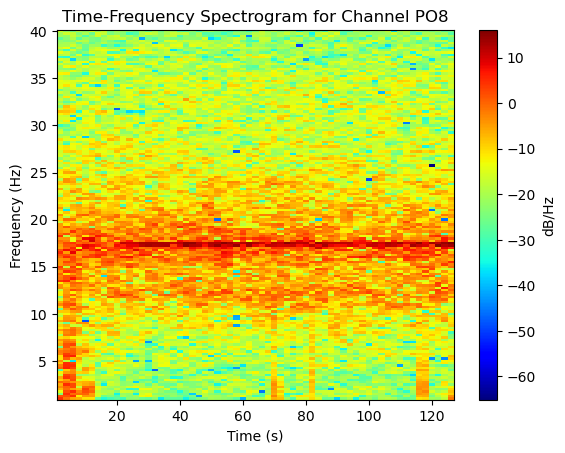

In [62]:
# Plot the spectrogram of the filtered EEG signal using spectrogram_cp function
f, t__,Spect_eeg = spectrogram_cp(y_hat,fs,True,chan_name)


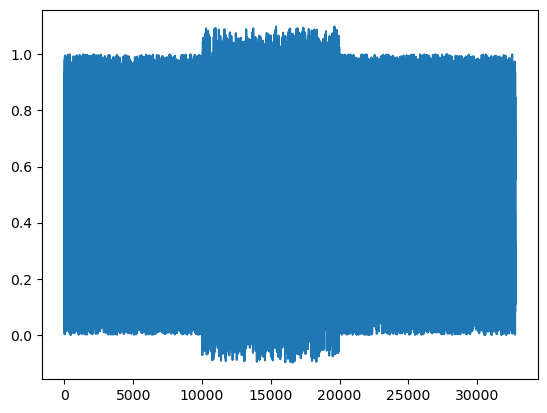

In [64]:
# Generate a random signal. This is the signal that will be used to test the RLS filter. 
x = np.random.rand(1,samples_nr)

# Slightly amplify the 17 Hz component of the signal in the second 10000 samples 
x[0,10000:20000] = x[0,10000:20000] + 0.1*np.sin(2*np.pi*17*np.arange(10000)/fs)
#Transpose the signal
x = x.T

# Plot the signal
plt.figure()
plt.plot(x[:,0])
plt.show()

# Apply the recursive least squares filter to each of the channels in the EEG signal with a target frequency of 17 Hz
y_hat = []
# Initialize a list to store the RLS filter coefficients
filter_coefficients = []

y_hat,filter_coefficients = rls_filter(x,17,0.95,fs,1e-4)


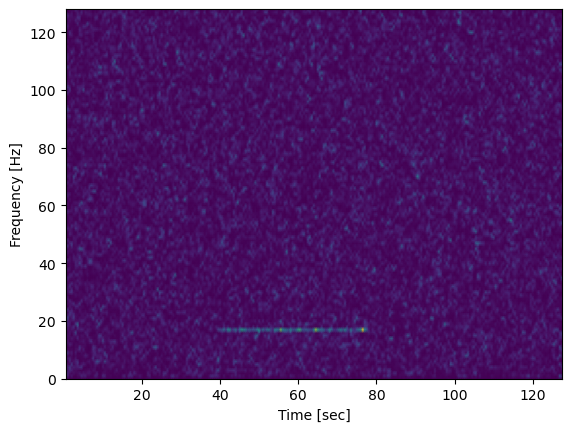

In [65]:
#plot the spectrogram of the signal x usings signal.spectrogram
f, t, Sxx = signal.spectrogram(x[:,0], fs, nperseg=256, noverlap=128, nfft=256, scaling='spectrum')
plt.figure()
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


(2, 32768)


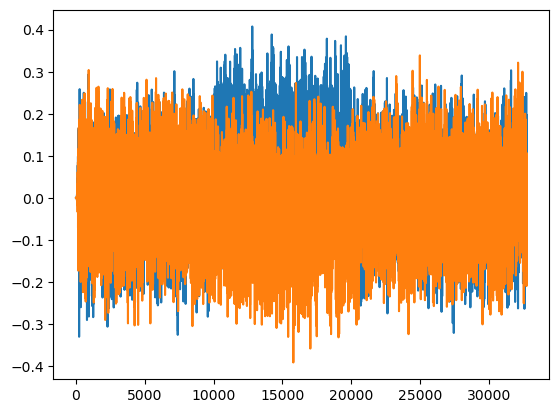

In [66]:
print(filter_coefficients.shape)
plt.figure()
plt.plot(filter_coefficients[0,:])
plt.plot(filter_coefficients[1,:])
plt.show()


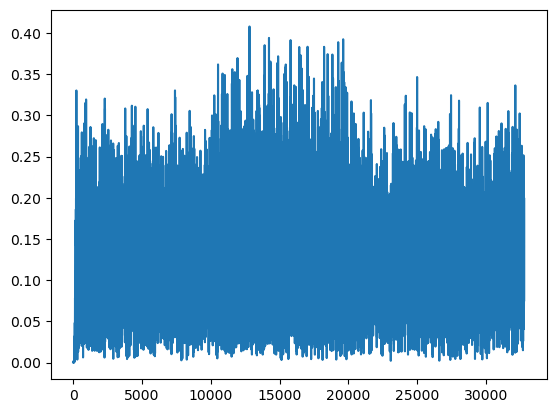

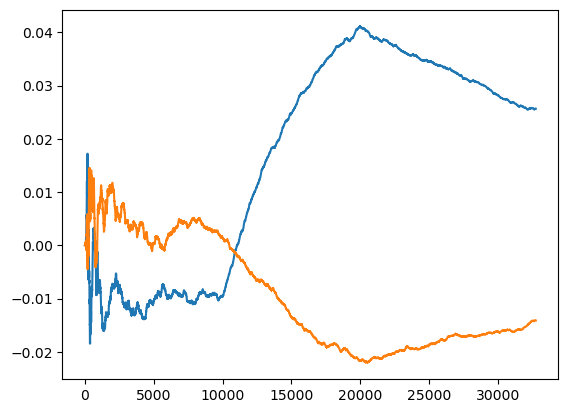

In [67]:
# Calculate the amplitude of the filter coefficients
amp_test = []
for i in range(len(filter_coefficients[0])):
    amp_test.append(np.sqrt(filter_coefficients[0,i]**2 + filter_coefficients[1,i]**2))
    
plt.figure()
plt.plot(amp_test)
plt.show()

# loop over the list w_5
moving_avg_1 = []
moving_avg_2 = []
for i in range(len(filter_coefficients[0])):
    moving_avg_1.append(sum(filter_coefficients[0,:i])/(i+1))
    moving_avg_2.append(sum(filter_coefficients[1,:i])/(i+1))
# Plot the coherent average
plt.figure()
plt.plot(moving_avg_1)
plt.plot(moving_avg_2)   
plt.show()

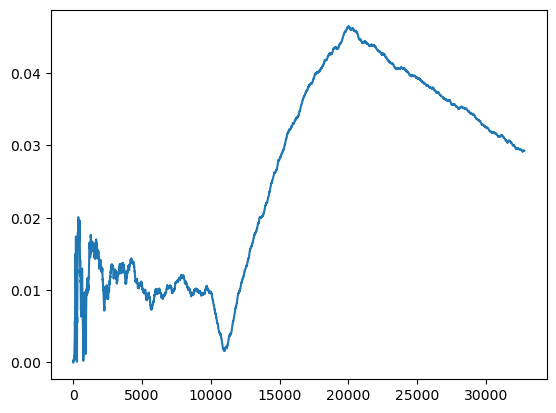

In [68]:
amp_improved_test = []
for i in range(len(filter_coefficients[0])):
    amp_improved_test.append(np.sqrt(moving_avg_1[i]**2 + moving_avg_2[i]**2))
    
plt.figure()
plt.plot(amp_improved_test)
plt.show()

(32768, 1)


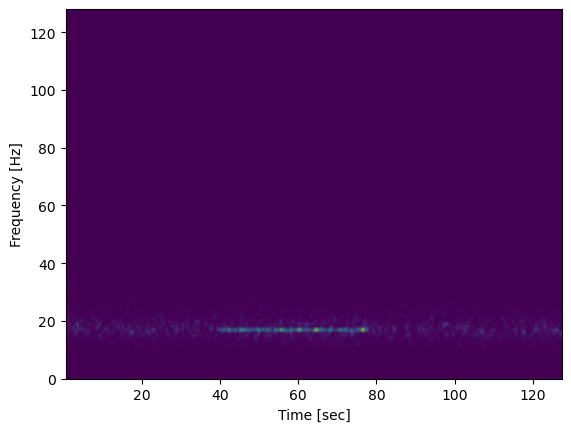

In [69]:
print(y_hat.shape)
# Plot the spectogram of the signal x not using the spectogram_cp function
f, t, Sxx = signal.spectrogram(y_hat[:,0], fs, nperseg=256, noverlap=128, scaling='spectrum')
plt.figure()
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
